In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

torch.manual_seed(42) # makes it reproducable
transform = T.Compose([ # This creates a transformation pipeline using T.Compose. It takes a list of transformations as input and applies them sequentially.
    T.ToTensor(), # converts the input image (which might be a PIL Image or a NumPy array) to a PyTorch tensor.
    T.Normalize([0.5],[0.5])]) # normalizes the pixel values of the image to be between [-1, 1] for greyscale images. It subtracts the mean value (0.5 in this case) from each pixel and then divides by the standard deviation (also 0.5 in this case). Normalizing data is often beneficial for training neural networks as it can help improve convergence speed and performance.

In [3]:
train_set = torchvision.datasets.FashionMNIST( # Load fashion image set
    root='.',
    train=True,
    download=True,
    transform=transform) #  applies the transformations you defined earlier, which include converting the images to tensors and normalizing their pixel values. This normalization helps stabilize training by ensuring that the pixel values are centered around zero.


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.32MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.1MB/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader( # load data from trainset
    train_set,
    batch_size=batch_size,
    shuffle=True)


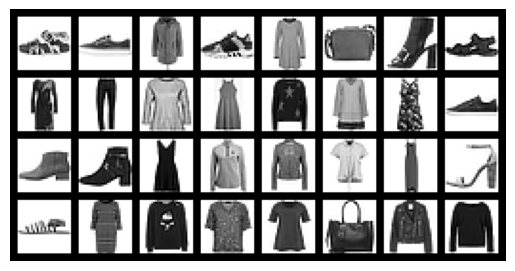

In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

images, labels = next(iter(train_loader)) # train_loader provides batches
# Plot all images of the 1st batch
grid = make_grid(0.5-images/2, 8, 4) # Create a grid. 0.5-images/2 coverts the previous normalisation from [-1,1] to (0,1) for matplotlib to understand, 8 columns, 4 rows.
plt.imshow(# displays the image grid using matplotlib.pyplot.imshow.
    grid.numpy().transpose((1, 2, 0)), #  converts the PyTorch tensor grid to a NumPy array and transpose((1, 2, 0)) rearranges the dimensions of the array to be compatible with imshow; It changes the order of the dimensions from (channels, height, width) to (height, width, channels), which is the format expected by imshow.
    cmap="grey_r") # sets the colormap to "grey_r", which displays the images in grayscale with reversed intensity.
plt.axis('off')
plt.show()

# Create Discriminator

In [16]:
import torch
import torch.nn as nn

# Determine the device automatically
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The discriminator D is a binary classifier
D = nn.Sequential(
    nn.Linear(784, 1024), # Layer 1, input of 784 neurons (likely flattened image data, 28x28 pixels = 784), which is mapped to 1024 neurons (all input neurons are mapped to all output neurons). The output number is greater to try to upsample to learn the features of the images.
    nn.ReLU(), #  Rectified Linear Unit: an activation function. It introduces non-linearity to the network, allowing it to learn more complex patterns. It is applied to the output of the previous linear layer.
    nn.Dropout(0.3), # Drop 30% of the input to prevent overfitting
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1), # mapped to 1 as it is binary classification where the output is between 0-1, where closer to 1 is truer and 0 is faker.
    nn.Sigmoid()).to(device) # Sigmoid is an activation function whcih makes the output between 0-1 aka False and True



# Generator to Create Greyscake Images

In [17]:
G = nn.Sequential(
    nn.Linear(100, 256), # 100 is random noise aka latenr space, a random input vector that is fed into the Generator (G). It acts as the starting point for the generator to create realistic-looking images.
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 784), # Mapped to 784 (aka image pixel dimension), because it produces the image!
    nn.Tanh()).to(device) # nn.Tanh(): the Tanh function ensures that the output values are scaled to the range [-1, 1], which matches the normalization used in task 1. Also makes training more stable by allowing gradients to flow smoothly reducing vanishing gradients

In [18]:
loss_fn = nn.BCELoss() # Loss fn measures the performance of the D and G. Binary Cross Entropy Loss (BCELoss) is used for binary classification
lr = 0.0001 # learning rate
optimD = torch.optim.Adam(D.parameters(), lr=lr) # Adam optimiser updates the parameters during training
optimG = torch.optim.Adam(G.parameters(), lr=lr)

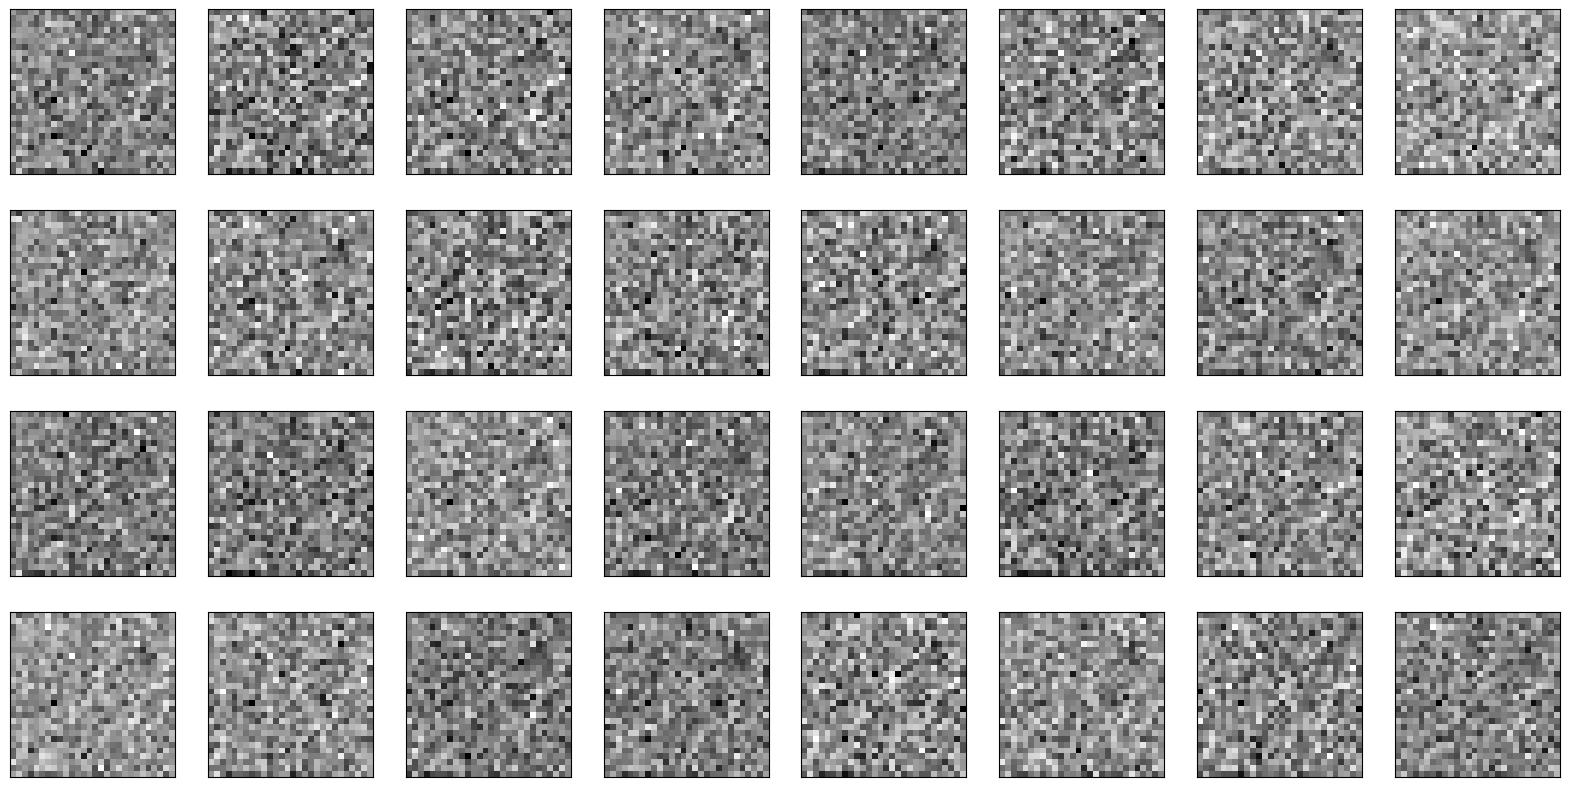

In [19]:
import matplotlib.pyplot as plt

# Generate and visualise fake samples from G
def see_output():
  noise = torch.randn(batch_size, 100).to(device=device) # batch of random noise. batch_size (32) makes 32 different noise vectors. 100 is "Latent space dimension" and is the dimensionality of each noise vector aka 100 random values. 100 is standard for lagom complexity.
  fake_samples = G(noise).cpu().detach()
  plt.figure(dpi=100, figsize=(20,10))
  for i in range(batch_size):
    ax=plt.subplot(4, 8, i+1) # the subplots make up 4 rows and 8 columns, i+1 is the index out of those for the current subplot.
    img=(fake_samples[i]/2+0.5).reshape(28,28) # reshapes each fake sample from a flat 784 dimesional vector to a 28x28 grid. "fake_samples[i]/2+0.5" brings them back to [0,1] (from [-1,1]) so that they can be displayed.
    plt.imshow(img, cmap="gray_r")
    plt.xticks([]) # removed from plt for better visualisation
    plt.yticks([]) # removed from plt for better visualisation
  plt.show()


see_output()

In [20]:
# Create tensors of 0s and 1s for real and fake labels
real_labels = torch.ones((batch_size, 1)).to(device)
fake_labels = torch.zeros((batch_size, 1)).to(device)

In [25]:
def train_D_on_real(real_samples): # batch of real images from the dataset
  r = real_samples.reshape(-1,28*28).to(device) # flattens into a vector of 784 elemetns, -1 is a special value that tells PyTorch to automatically calculate the appropriate dimension for that axis.
  out_D = D(r) # Discriminator makes predictions for each image (value between 0-1)
  labels = torch.ones((r.shape[0],1)).to(device) # since we are training on real data, we make a tensor of real labels (1s) that match the size of the batch (r.shape[0]) and the other dimension is 1 aka 32 (batch_size) rows and 1 column
  loss_D = loss_fn(out_D, labels) # calculates loss to measure between D's predictions and real labels
  optimD.zero_grad() # reset gradients of D's optimiser
  loss_D.backward() # Backpropagation; calculates the gradients of loss with respect to the D's parameters. Gradients indicate how parameters should be adjusted.
  optimD.step() # Updates D's parameters using the calculated gradients
  return loss_D # returns calculated loss for this batch

In [26]:
def train_D_on_fake(): # similar to above but with fake images
  noise = torch.randn(batch_size, 100).to(device=device) # random noise for 32 vectors with 100 values
  generated_data = G(noise) # generates images that attempt to look real
  preds = D(generated_data) # put throguh the discriminator to get predictions
  loss_D = loss_fn(preds, fake_labels) # images are assigned target label of 0 since they are fake and BCEloss fn calculates loss by comparing them to the predictions
  optimD.zero_grad() # reset gradients
  loss_D.backward() # backpropogation
  optimD.step() # Updates D parameters
  return loss_D

  # By alternating between training on real and fake images, the discriminator learns to become
  # better at distinguishing between the two. As training progresses, the generator also improves
  # because it aims to create images that can increasingly fool the discriminator. This adversarial
  # process helps both networks improve over time

In [27]:
def train_G(): # Training Generator
  noise = torch.randn(batch_size, 100).to(device=device) # random noise for 32 vectors with 100 values
  generated_data = G(noise) # Generator tries to transform noise into images that look real
  preds = D(generated_data) # put throguh the discriminator to get predictions
  loss_D = loss_fn(preds, real_labels) # Since the generator’s objective is to create images that look real, the labels assigned to these fake images are 1. This means the generator is trying to trick the discriminator into classifying its outputs as real. Loss fn compares the Ds predictions and the real labels
  optimD.zero_grad() # reset gradients
  loss_D.backward() # backpropogation
  optimD.step() # Updates D parameters
  return loss_D


at epoch 10, dloss: 0.6935420036315918, gloss: 0.6935871243476868


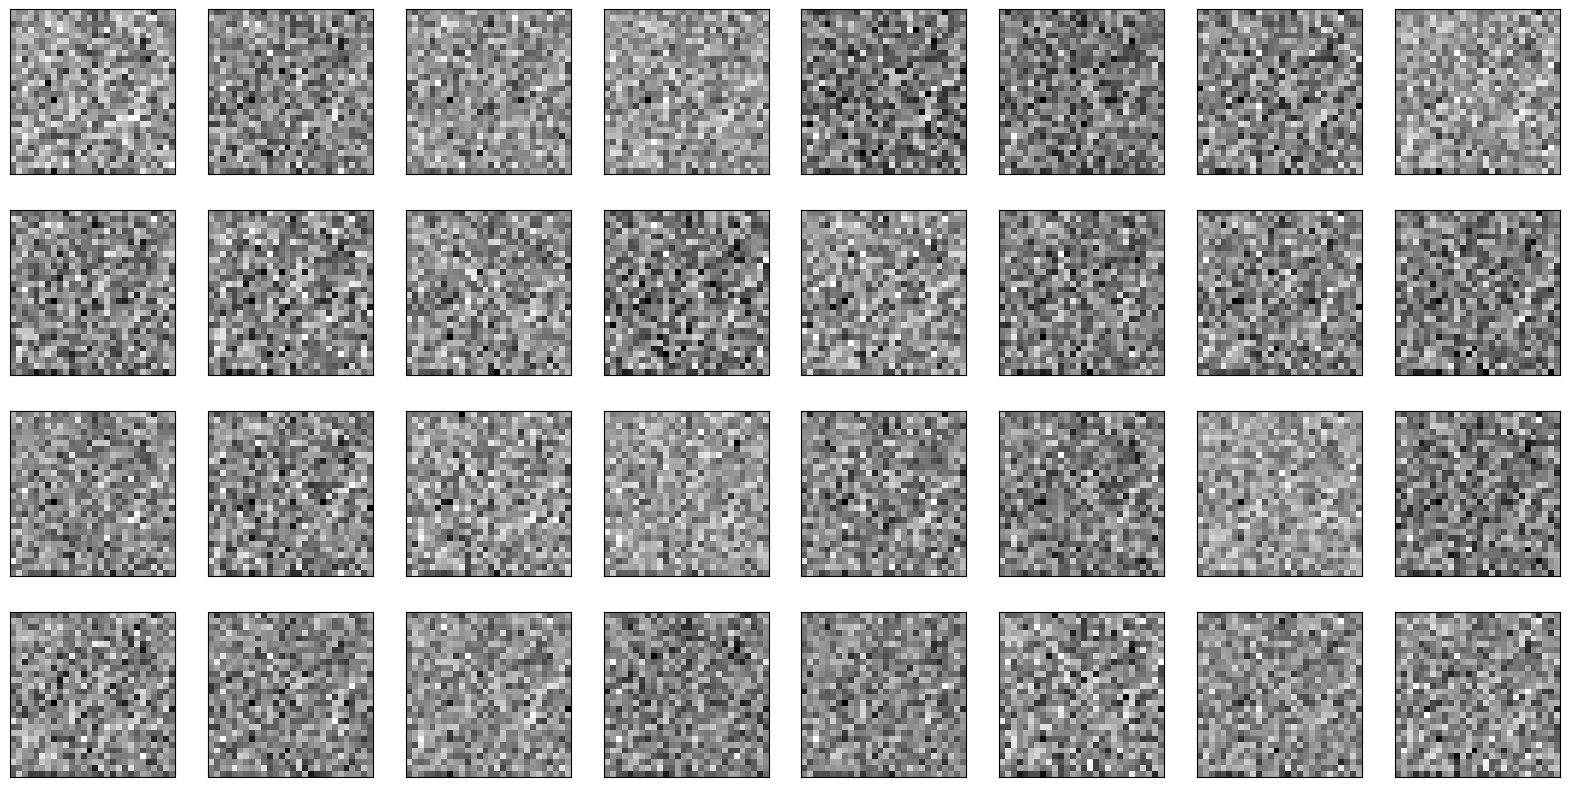

at epoch 20, dloss: 0.6941114068031311, gloss: 0.6929697394371033


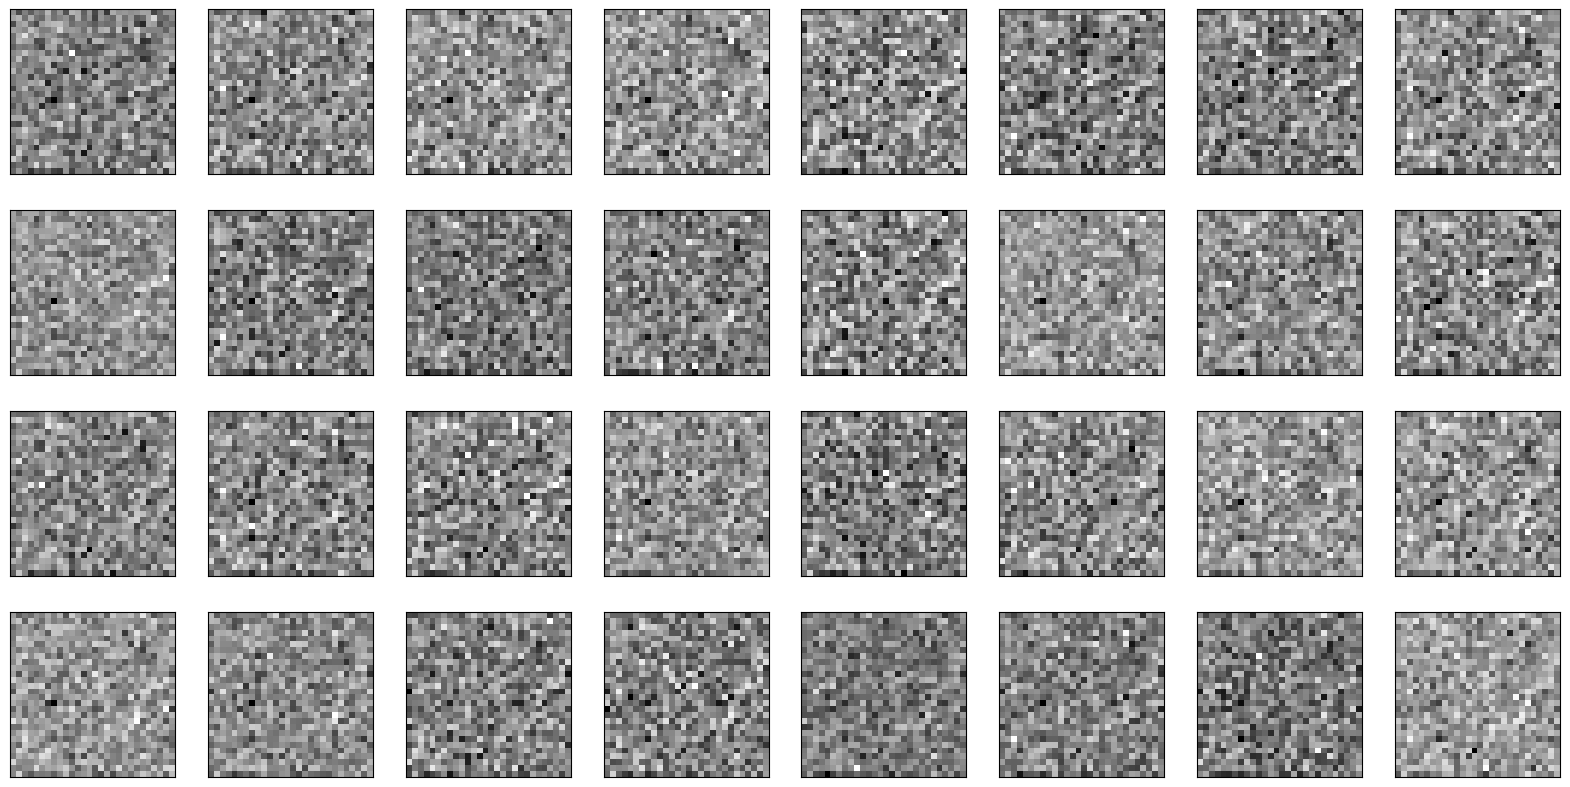

at epoch 30, dloss: 0.6937870979309082, gloss: 0.6932678818702698


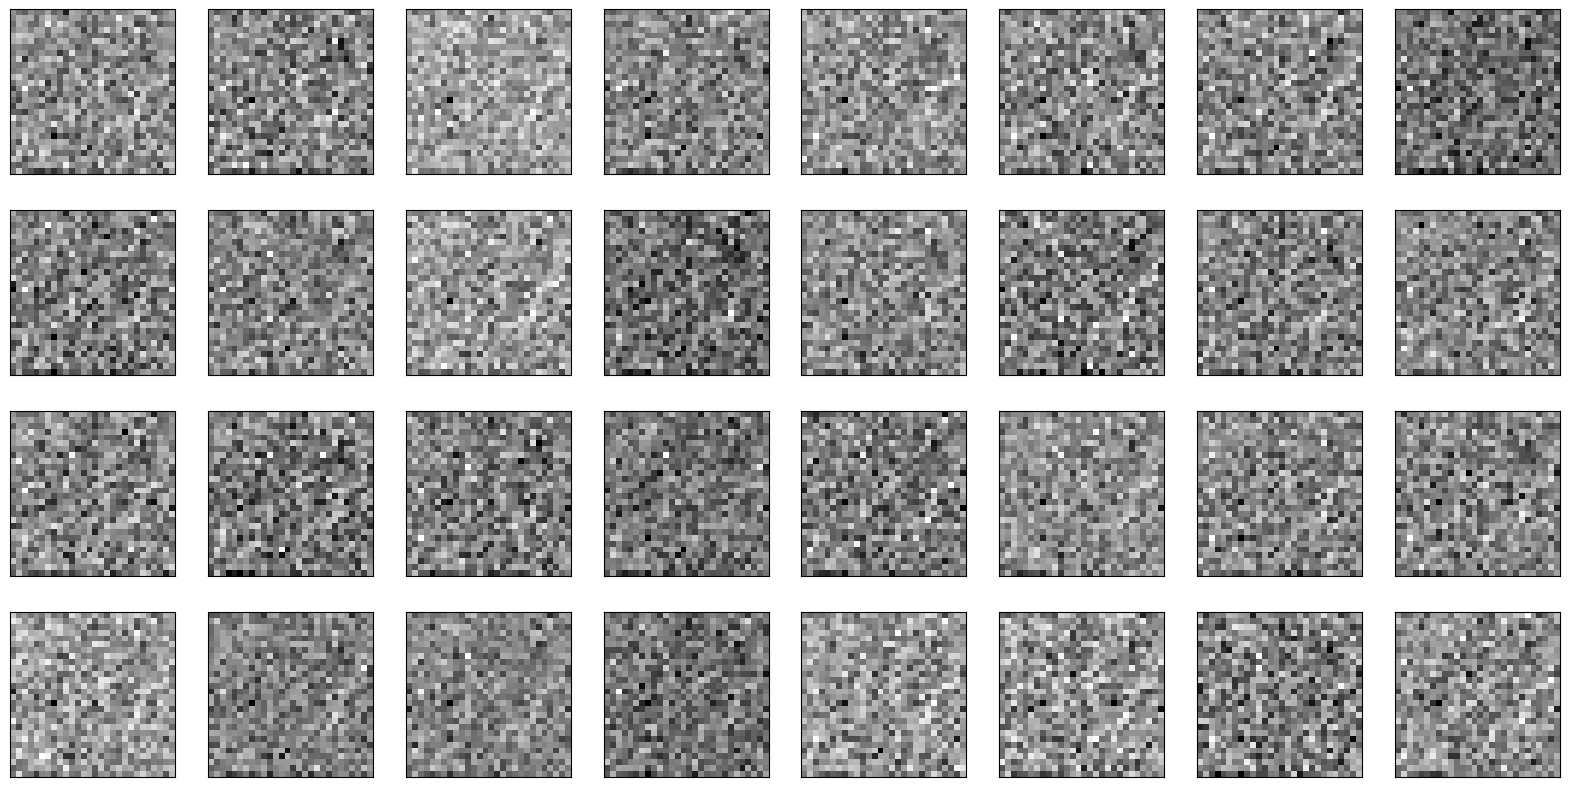

In [ ]:
for i in range(50): # 50 epochs
  gloss=0 # initalise acumulate loss for G
  dloss=0 # initalise acumulate loss for D
  for n, (real_samples,_) in enumerate(train_loader): # n is index of the batch, (real_samples, _) are real samples and labels (tho they are ignored in this case)
    loss_D = train_D_on_real(real_samples) # Train D on real samples and outputs loss
    dloss += loss_D # D loss is added to cumulative D loss
    loss_D = train_D_on_fake() # Train D on fake samples, outputs loss
    dloss += loss_D # D loss is added to cumulative D loss
    loss_G = train_G() # Train G to make more real looking images, outputs loss
    gloss += loss_G # G loss is added to cumulative G loss
  gloss = gloss/n # get average G loss across batches
  dloss = dloss/n # get average D loss across batches
  if i % 10 == 9: # every 10th epoch
    print(f"at epoch {i+1}, dloss: {dloss}, gloss: {gloss}")
    see_output()



In [ ]:
# The code in the two boxes below is designed to work with TorchScript, a way to serialize and optimize PyTorch models for deployment.

# Export to TorchScript
scripted = torch.jit.script(G) # converts PyTorch model to TorchScript format

# Save model
import os
os.makedirs("files", exist_ok=True)
scripted.save("files/fashion_gen.pt")

In [ ]:
# Loading the saved TorchScript model

new_G = torch.jit.load("files/fashion_gen.pt", map_location=device) # model is loaded to specified device

new_G.eval() #  sets the model to evaluation mode ensuring that layers such as dropout and batch normalization behave appropriately during inference

# "Behave  appropriately during inference":
# some layers in a neural network such as dropout and batch normalization function differently
# during training versus inference (aka testing or deployment). Calling eval() on a PyTorch
# model ensures that these layers switch to their inference behaviour.

# Dropout:
# During training dropout layers randomly deactivate a fraction of neurons in a layer to prevent
# overfitting. This helps the model generalize better by making it less reliant on specific
# neurons. However during inference dropout is disabled so that all neurons contribute to the
# predictions ensuring consistent and reliable outputs

# Normalisation:
# Batch normalization also behaves differently in training versus inference. In training mode
# batch normalization calculates the mean and variance of the current mini-batch and
# normalizes the activations accordingly. It also keeps track of a moving average of these
# statistics to use later. During inference, instead of computing statistics from the current batch,
# batch normalization uses the stored moving averages thus ensuring stable and consistent
# normalization across different inputs.

# f eval() is not called before inference dropout will deactivate neurons leading to
# inconsistent predictions and batch normalization will continue updating its statistics,
# potentially causing shifts in model behaviour. Calling eval() ensures that these layers
# function as intended for making predictions resulting in stable and accurate outputs.

In [ ]:
noise=torch.randn(batch_size,100).to(device=device) # create noise tensor with 32 vectors (batch_size) and 100 values, then moved to the device (CPU or GPU)
fake_samples = new_G(noise).cpu().detach() # noise is passed through a traind generator model "new_G" to generate fake samples. cpu() ensures tensor is moved to the CPU for visualization and .detach() is used to break the computational graph preventing gradients from being tracked which is necessary since the generated images are not part of a backpropagation step
plt.figure(dpi=100, figsize=(10,5))
for i in range(32):
  ax = plt.subplot(4,8,i+1) # # the subplots make up 4 rows and 8 columns, i+1 is the index out of those for the current subplot.
  plt.imshow((fake_samples[i]/2+0.5).reshape(28,28), cmap="grey_r") # reshapes each fake sample from a flat 784 dimesional vector to a 28x28 grid. "fake_samples[i]/2+0.5" brings them back to [0,1] (from [-1,1]) so that they can be displayed.
  plt.xticks=([])
  plt.yticks=([])
plt.subplots_adjust(hspace=-0.6) # reduce vertical spacing between the images for a more compact layout
plt.show()